In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot exetent/area from observations and models (past and future)
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')


from esio import EsioData as ed
from esio import ice_plot
from esio import import_data

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  F

In [2]:
# Plotting Info
runType = 'forecast'
variables = ['sic'] #, 'hi'
metric1 = 'extent'

In [3]:
# Initialization times to plot
cd = datetime.datetime.now()
cd = datetime.datetime(cd.year, cd.month, cd.day) # Assumes hours 00, min 00

SD = cd - datetime.timedelta(days=45)
SD = datetime.datetime(SD.year,SD.month,1) # always start on first of month

ED = cd + datetime.timedelta(days=365)
print(SD)

2019-03-01 00:00:00


In [4]:
# Models not to plot
no_plot = ['rasmesrl','noaasipn']

In [5]:
#############################################################
# Load in Data
#############################################################
E = ed.EsioData.load()

In [6]:
# Load in Observations
# ds_51 = xr.open_mfdataset(E.obs['NSIDC_0051']['sipn_nc']+'/*.nc',
#                         concat_dim='time', autoclose=True, 
#                         compat='no_conflicts', data_vars=['sic','extent','area'])['extent']
# ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'/*.nc', concat_dim='time', autoclose=True)
# ds_79 = xr.open_mfdataset(E.obs['NSIDC_0079']['sipn_nc']+'/*.nc',
#                         concat_dim='time', autoclose=True, 
#                         compat='no_conflicts', data_vars=['sic','extent','area'])['extent']
ds_ext = xr.open_dataset(os.path.join(E.obs['NSIDC_extent']['sipn_nc'], 'N_seaice_extent_daily_v3.0.nc'))
ds_ext = ds_ext.rename({'datetime':'time'})

ds_obs_PAall = ds_ext.Extent.where(ds_ext.time>=np.datetime64(SD), drop=True)   # PAall includes CA Is and SJ

In [7]:
# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))

In [8]:
ds_obs_reg = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/*.nc', concat_dim='time')#,
ds_obs_reg = ds_obs_reg.sic.where(ds_obs_reg.time>=np.datetime64(SD), drop=True)
ds_obs_CA = ds_obs_reg.where(ds_region.mask==14)
ds_obs_CA = ((ds_obs_CA >= 0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)
ds_obs_SJ = ds_obs_reg.where(ds_region.mask==5)
ds_obs_SJ = ((ds_obs_SJ >= 0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)

ds_obs=ds_obs_PAall-ds_obs_CA-ds_obs_SJ

In [9]:
cdate = datetime.datetime.now()

In [10]:
# this might be kind of cool but it is not working at the moment. it was used to make a figure in the lower section
plotquartiles = False  # turn it off
#ds_per = ds_obs.sel(time=slice('1980','2010'))
#DOY = [x.timetuple().tm_yday for x in pd.to_datetime(ds_per.time.values)]
#ds_per['time'] = DOY # replace
#ds_per_mean = ds_per.groupby('time').mean().Extent
#ds_per_std = ds_per.groupby('time').std().Extent
## Adjust dates to this year
#ds_per_mean['time'] = (ds_per_mean.time -1).astype('timedelta64[D]') + np.datetime64(datetime.datetime(cdate.year,1,1))
#ds_per_std['time'] = (ds_per_std.time -1).astype('timedelta64[D]') + np.datetime64(datetime.datetime(cdate.year,1,1))
## append next year because some plots go into future
#ds_per_mean_2 = ds_per_mean.copy()
#ds_per_std_2 = ds_per_std.copy()
#
#ds_per_mean_2['time'] = ds_per_mean_2.time + np.timedelta64(ds_per_mean.time.size,'D')
#ds_per_mean = xr.concat([ds_per_mean,ds_per_mean_2], dim='time')
#
#ds_per_std_2['time'] = ds_per_std_2.time + np.timedelta64(ds_per_std.time.size,'D')
#ds_per_std = xr.concat([ds_per_std,ds_per_std_2], dim='time')

In [11]:
def plot_user_Extent():
    # Hack plot of models that only provide bias corrected SIE
    model= 'noaasipn'
    data_dir = os.path.join('/home/disk/sipn/upload/', model, runType)
    prefix = 'sie2'
    all_files = sorted(glob.glob(os.path.join(data_dir, '**', prefix+'*.nc'), recursive=True))
    clabel = label='ncep-exp-bias-corr'
    for cf in all_files:
        ds_model = xr.open_mfdataset(cf, concat_dim='time').rename({'ens':'ensemble','sie':'Extent','time':'valid_time'}, inplace=True)
        ds_model = ds_model.where(ds_model.valid_time>=np.datetime64(SD), drop=True).Extent
        ds_model.coords['valid_time'] = ds_model.valid_time + np.timedelta64(15, 'D') # monthly average, so plot point as middle of month (not ideal but no daily available)
        
        for e in ds_model.ensemble:
            ds_model.sel(ensemble=e).plot( label=clabel, color='k', linewidth=1, alpha=0.5)
            clabel = '_nolegend_'

# Plot Raw extents and only models that predict sea ice

dampedAnomalyTrend
Plotting...
0.5334529224783182  seconds.
gfdlsipn
Plotting...
0.15972843952476978  seconds.
piomas
yopp
Plotting...
0.8871879409998655  seconds.
ukmetofficesipn
Plotting...
0.11404445767402649  seconds.
ecmwfsipn
Plotting...
2.2292927727103233  seconds.
ecmwf
Plotting...
0.07736345939338207  seconds.
metreofr
Plotting...
0.033201372250914574  seconds.
ukmo
Plotting...
0.24176647700369358  seconds.
kma
Plotting...
0.24256573617458344  seconds.
ncep
Plotting...
0.25079640187323093  seconds.
usnavysipn
Plotting...
0.004090188071131706  seconds.
usnavyncep
Plotting...
0.3553522117435932  seconds.
noaasipn_ext
usnavygofs
Plotting...
3.112562730908394  seconds.
modcansipns_3
Plotting...
0.025718456134200096  seconds.
modcansipns_4
Plotting...
0.025792621076107025  seconds.
uclsipn
Plotting...
0.02212132140994072  seconds.
szapirosipn
Plotting...
0.01406823843717575  seconds.
awispin
Plotting...
0.025060733780264854  seconds.
nicosipn
Plotting...
0.009625053033232689  secon

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


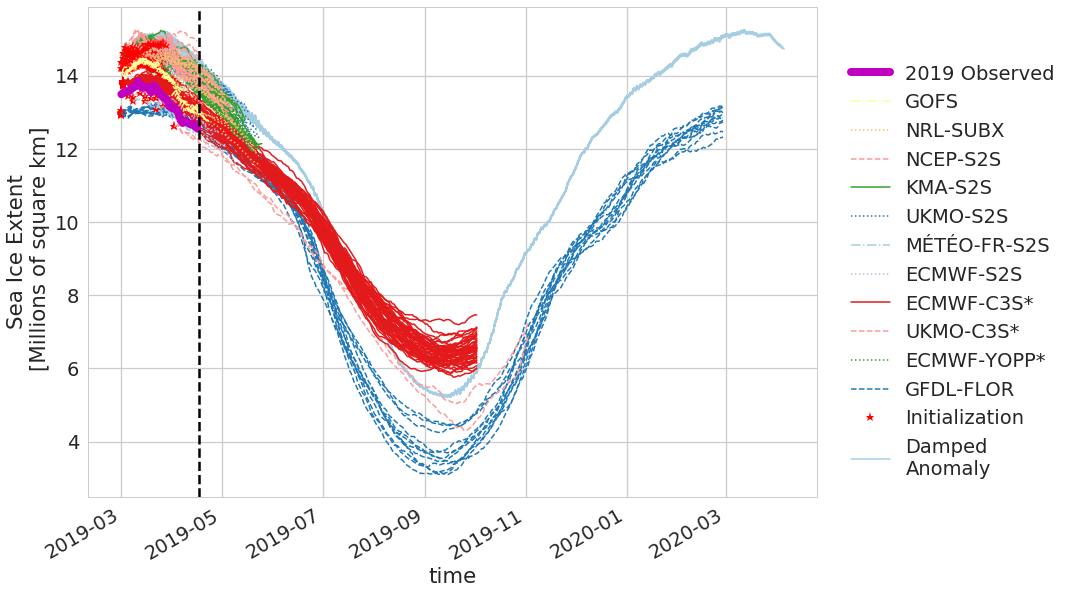

In [12]:
# cmap_c = itertools.cycle(sns.color_palette("Paired", len(E.model.keys()) ))
# linecycler = itertools.cycle(["-","--","-.",":","--"])
for cvar in variables:
    
    fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar, "timeseries")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    # New Plot
    f = plt.figure(figsize=(15,10))
    ax1 = plt.subplot(1, 1, 1) # Observations
    
#     for (i, cmod) in enumerate(['uclsipn']):
    for (i, cmod) in enumerate(E.model.keys()):
        if cmod in no_plot:
            continue
        
        if not E.icePredicted[cmod]:
            continue
        print(cmod)
        
        # Load in Model
        model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc_agg'], '*.nc')

        # Check we have files 
        files = glob.glob(model_forecast)
        if not files:
            #print("Skipping model", cmod, "no forecast files found.")
            continue # Skip this model
        ds_model = xr.open_mfdataset(model_forecast, concat_dim='init_time')
         
        # Get Extent
        ds_model = ds_model.Extent
        
        # Select the panArctic Region (99)
        ds_model = ds_model.sel(nregions=99)
            
        # Select init of interest
        ds_model = ds_model.where(ds_model.init_time >= np.datetime64(SD), drop=True)
        
        # Get model plotting specs
        cc = E.model_color[cmod]
        cl = E.model_linestyle[cmod]

        # Plot Model
        print('Plotting...')
#         print(ds_model)
        if i == 1: # Control only one initiailzation label in legend
            no_init_label = False
        else:
            no_init_label = True
        import timeit
        start_time = timeit.default_timer()
        #ds_model.load()
#         print(ds_model)
#         xr.exit()
        ice_plot.plot_reforecast(ds=ds_model, axin=ax1, 
                             labelin=E.model[cmod]['model_label'],
                             color=cc, marker=None,
                             linestyle=cl,
                             no_init_label=no_init_label,
                             fade_out=False)
        print( (timeit.default_timer() - start_time), ' seconds.' )
        
        # Memory clean up
        ds_model = None
        
    # Hack plot of models that only provide bias corrected SIE
#    plot_user_Extent()
        
    # Plot observations
    print('Plotting observations')
    ds_obs.plot(ax=ax1, label=str(cdate.year)+' Observed', color='m', linewidth=8)
    ax1.set_ylabel('Sea Ice Extent\n [Millions of square km]')
    cxlims = ax1.get_xlim()

#     # 1980-2010 Historical Interquartile Range
#     plt.fill_between(ds_per_mean.time.values, ds_per_mean + ds_per_std, 
#                  ds_per_mean - ds_per_std, alpha=0.35, label='1980-2010\nInterquartile Range', color='m')
    ax1.set_xlim(cxlims) # fix x limits
    cylims = ax1.get_ylim()
    
    # Plot current date line
    ax1.plot([cd, cd], [cylims[0], cylims[1]], color='k', linestyle='--')
    
    # Add legend (static)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[::-1], labels[::-1], loc='lower right',bbox_to_anchor=(1.35, 0))
    
    f.autofmt_xdate()
    ax1.set_ylim(cylims)
    plt.subplots_adjust(right=.8)
        
    # Save to file
    f_out = os.path.join(fig_dir,'panArctic_'+metric1+'_'+runType+'_raw_predicted.png')
    f.savefig(f_out,bbox_inches='tight',dpi=200)
#    mpld3.save_html(f, os.path.join(fig_dir,'panArctic_'+metric1+'_'+runType+'_raw_predicted.html'))


# Plot raw extents with interquartile range, broken at the moment

dampedAnomalyTrend
Plotting...
0.5007923003286123  seconds.
gfdlsipn
Plotting...
0.1679802816361189  seconds.
piomas
yopp
Plotting...
0.9042304363101721  seconds.
ukmetofficesipn
Plotting...
0.14856671914458275  seconds.
ecmwfsipn
Plotting...
2.379052098840475  seconds.
bom
Plotting...
0.06903847306966782  seconds.
cma
Plotting...
0.2427422609180212  seconds.
ecmwf
Plotting...
0.07714753039181232  seconds.
hcmr
Plotting...
0.033694030717015266  seconds.
isaccnr
Plotting...
0.03991478681564331  seconds.
jma
Plotting...
0.03433251194655895  seconds.
metreofr
Plotting...
0.03207811713218689  seconds.
ukmo
Plotting...
0.2397334035485983  seconds.
eccc
Plotting...
0.03315053507685661  seconds.
kma
Plotting...
0.24184726364910603  seconds.
ncep
Plotting...
0.3043836709111929  seconds.
usnavysipn
Plotting...
0.00441979244351387  seconds.
usnavyncep
Plotting...
0.36013105511665344  seconds.
noaasipn_ext
usnavygofs
Plotting...
3.092736406251788  seconds.
modcansipns_3
Plotting...
0.025752406567

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


NameError: name 'ds_per_mean' is not defined

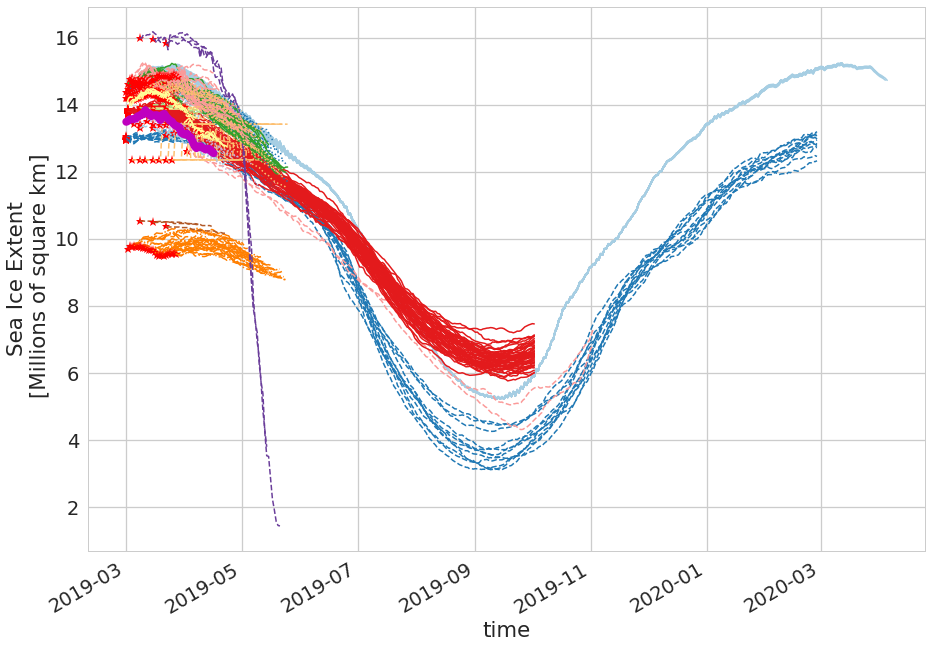

In [16]:
if plotquartiles:
    for cvar in variables:

        fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar, "timeseries")
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)

        # New Plot
        f = plt.figure(figsize=(15,10))
        ax1 = plt.subplot(1, 1, 1) # Observations

        for (i, cmod) in enumerate(E.model.keys()):
            if cmod in no_plot:
                continue
    #     for (i, cmod) in enumerate(['ukmetofficesipn']):
            print(cmod)

            # Load in model
            model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc_agg'], '*.nc')

            # Check we have files 
            files = glob.glob(model_forecast)
            if not files:
                #print("Skipping model", cmod, "no forecast files found.")
                continue # Skip this model
            ds_model = xr.open_mfdataset(model_forecast, concat_dim='init_time')

            # Get Extent
            ds_model = ds_model.Extent

            # Select the panArctic Region (99)
            ds_model = ds_model.sel(nregions=99)

            # Select init of interest
            ds_model = ds_model.where(ds_model.init_time >= np.datetime64(SD), drop=True)

            # Get model plotting specs
            cc = E.model_color[cmod]
            cl = E.model_linestyle[cmod]

            # Plot Model
            print('Plotting...')
    #         print(ds_model)
            if i == 1: # Control only one initiailzation label in legend
                no_init_label = False
            else:
                no_init_label = True
            import timeit
            start_time = timeit.default_timer()
            #ds_model.load()
    #         print(ds_model)
            ice_plot.plot_reforecast(ds=ds_model, axin=ax1, 
                                 labelin=E.model[cmod]['model_label'],
                                 color=cc, marker=None,
                                 linestyle=cl,
                                 no_init_label=no_init_label)
            print( (timeit.default_timer() - start_time), ' seconds.' )

            # Memeory clean up
            ds_model = None

        # Hack plot of models that only provide bias corrected SIE
    #    plot_user_Extent()    


        # Plot observations
        print('Plotting observations')
        ds_obs.where(ds_obs.time>=np.datetime64(SD), drop=True).plot(ax=ax1, label=str(cdate.year)+' Observed', color='m', linewidth=8)
        ax1.set_ylabel('Sea Ice Extent\n [Millions of square km]')
        cxlims = ax1.get_xlim()

        # 1980-2010 Historical Interquartile Range
        plt.fill_between(ds_per_mean.time.values, ds_per_mean + ds_per_std, 
                     ds_per_mean - ds_per_std, alpha=0.35, label='1980-2010\nInterquartile Range', color='m')
        ax1.set_xlim(cxlims) # fix x limits
        cylims = ax1.get_ylim()

        # Plot current date line
        ax1.plot([cd, cd], [cylims[0], cylims[1]], color='k', linestyle='--')

        # Add legend (static)
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles[::-1], labels[::-1], loc='lower right',bbox_to_anchor=(1.35, 0))

        f.autofmt_xdate()
        ax1.set_ylim(cylims)
        plt.subplots_adjust(right=.8)

        # Save to file
        f_out = os.path.join(fig_dir,'panArctic_'+metric1+'_'+runType+'_raw_all.png')
        f.savefig(f_out, bbox_inches='tight',dpi=200)
    #     mpld3.save_html(f, os.path.join(fig_dir,'panArctic_'+metric1+'_'+runType+'_raw_all.html'))
